In [2]:
%pip -q install numpy matplotlib scikit-fuzzy pillow opencv-python scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [7]:
def retinal_vessel_extraction(image_path, n_clusters=2):
    # Step 1: Load Image
    img = cv2.imread(image_path)
    green_channel = img[:, :, 1]  # Extract green channel for better contrast
    
    # Step 2: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(green_channel)
    
    # Step 3: Gabor Filter for Feature Extraction
    kernel_size = 31
    sigma = 4.0
    theta = np.pi / 4
    lambd = 10.0
    gamma = 0.5
    psi = 0
    gabor_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    gabor_filtered = cv2.filter2D(enhanced_image, cv2.CV_8UC1, gabor_kernel)
    
    # Step 4: Hessian-based Enhancement without skimage
    # Approximate Hessian enhancement using second order derivatives
    hessian_xx = cv2.Sobel(gabor_filtered, cv2.CV_64F, 2, 0, ksize=5)
    hessian_yy = cv2.Sobel(gabor_filtered, cv2.CV_64F, 0, 2, ksize=5)
    hessian_enhanced = np.sqrt(hessian_xx**2 + hessian_yy**2)
    hessian_enhanced = (hessian_enhanced / hessian_enhanced.max() * 255).astype(np.uint8)
    
    # Step 5: K-means Clustering for Vessel Segmentation
    pixels = hessian_enhanced.flatten().reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pixels)
    segmented = kmeans.labels_.reshape(hessian_enhanced.shape)
    segmented = (segmented == 1).astype(np.uint8)  # Extract the vessel cluster
    
    # Step 6: Morphological Cleaning
    kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)
    
    # Step 7: Plotting Results
    plt.figure(figsize=(18, 12))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title('CLAHE Enhanced')
    plt.imshow(enhanced_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title('Hessian Enhanced')
    plt.imshow(hessian_enhanced, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title('Final Vessel Segmentation')
    plt.imshow(cleaned, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return cleaned

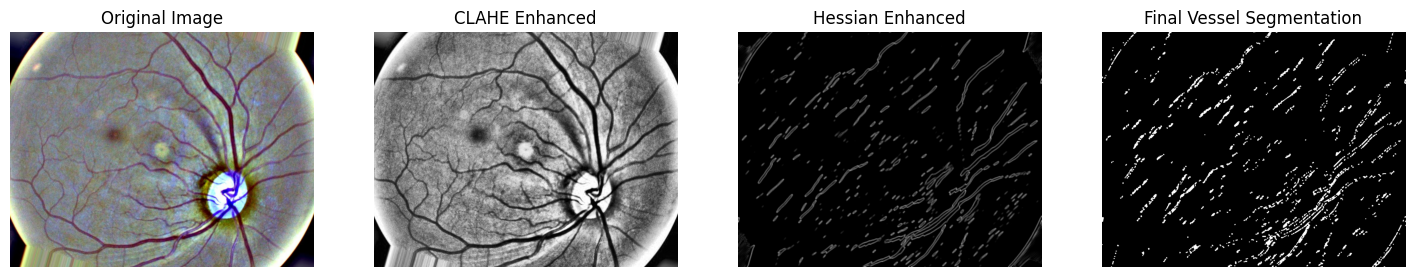

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
# Example Usage
retinal_vessel_extraction('DR1.jpeg')